In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from trainmodel import prepare_input_data
import matplotlib.pyplot as plt


2024-04-15 13:30:00.074159: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load and prepare data using the prepare_input_data function from trainmodel.py
X, y, word_index, class_weights = prepare_input_data('processed_reviews.csv')


In [3]:
def define_lstm_model(vocab_size, embedding_dim=64, lstm_units=128, dropout_rate=0.5):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        LSTM(units=lstm_units),
        Dropout(dropout_rate),
        Dense(units=50, activation='relu'),
        Dropout(dropout_rate),
        Dense(units=3, activation='softmax')  # Assuming three sentiment classes: Negative, Neutral, Positive
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [4]:
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create the model
    model = define_lstm_model(len(word_index) + 1)  # +1 for zero-padding token
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    print(f'Training fold {fold_no}...')
    history = model.fit(X_train, y_train, batch_size=64, epochs=10,
                        class_weight=class_weights, validation_data=(X_test, y_test),
                        callbacks=[early_stopping])
    
    # Evaluate the model on the test set
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])
    fold_no += 1


Training fold 1...
Epoch 1/10
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 233s 120ms/step - accuracy: 0.4301 - loss: 1.0881 - val_accuracy: 0.1097 - val_loss: 1.0943
Epoch 2/10
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 235s 122ms/step - accuracy: 0.5274 - loss: 1.0076 - val_accuracy: 0.7773 - val_loss: 0.4975
Epoch 3/10
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 235s 122ms/step - accuracy: 0.7766 - loss: 0.6225 - val_accuracy: 0.8187 - val_loss: 0.4522
Epoch 4/10
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 234s 121ms/step - accuracy: 0.8090 - loss: 0.5291 - val_accuracy: 0.7695 - val_loss: 0.5079
Epoch 5/10
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 238s 123ms/step - accuracy: 0.8298 - loss: 0.4675 - val_accuracy: 0.8176 - val_loss: 0.4553
Epoch 6/10
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 245s 127ms/step - accuracy: 0.8492 - loss: 0.4163 - val_accuracy: 0.7850 - val_loss: 0.5247
Score for fold 1: loss of 0.4523169994354248; compile_metrics of 0.8186825513839722
Training fold 2...
Epoch 1/10
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 256s 132ms/step - accuracy: 0.37

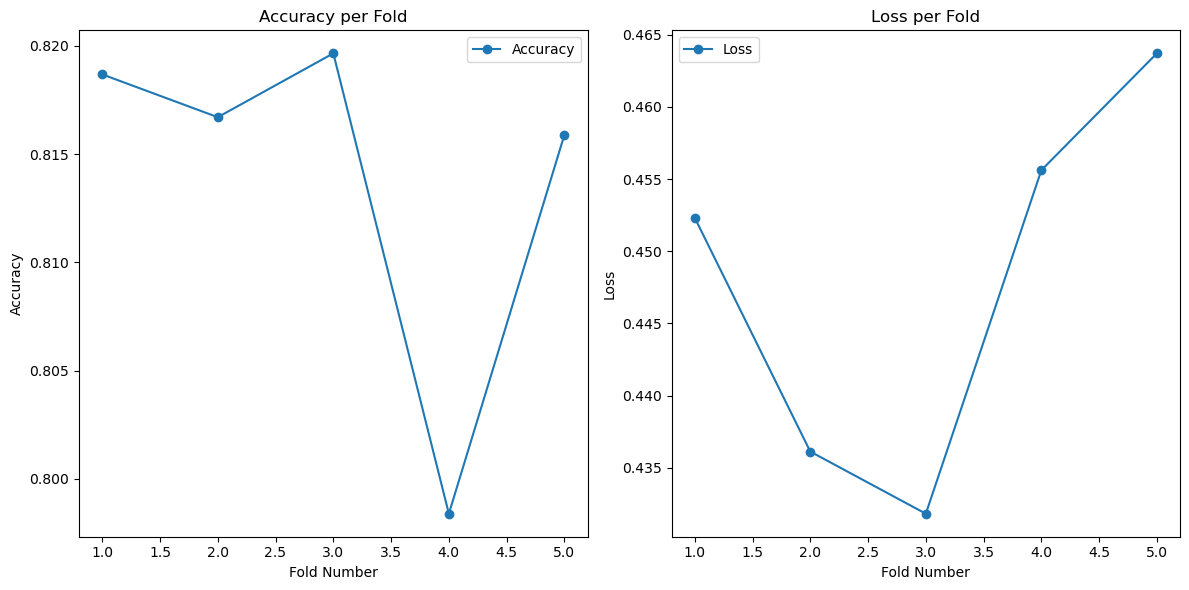

In [5]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, k+1), acc_per_fold, marker='o', label='Accuracy')
plt.title('Accuracy per Fold')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, k+1), loss_per_fold, marker='o', label='Loss')
plt.title('Loss per Fold')
plt.xlabel('Fold Number')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
# Calculating mean and standard deviation for model accuracy and loss
mean_accuracy = np.mean(acc_per_fold)
std_accuracy = np.std(acc_per_fold)
mean_loss = np.mean(loss_per_fold)
std_loss = np.std(loss_per_fold)

print(f"Mean Accuracy across folds: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Mean Loss across folds: {mean_loss:.4f} ± {std_loss:.4f}")


Mean Accuracy across folds: 0.8139 ± 0.0079
Mean Loss across folds: 0.4479 ± 0.0120


## Hyper parameter tunning 

In [25]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import HyperModel, RandomSearch
from trainmodel import prepare_input_data


In [26]:
vocab_size = len(word_index) + 1

In [27]:
class LSTMHyperModel(HyperModel):
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size

    def build(self, hp):
        model = Sequential()
        model.add(Embedding(
            input_dim=self.vocab_size, 
            output_dim=hp.Int('embedding_dim', min_value=32, max_value=128, step=32)
        ))
        model.add(LSTM(
            units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
            return_sequences=hp.Boolean('return_sequences')
        ))
        model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
        model.add(LSTM(
            units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
            return_sequences=False  # Ensures this is false for the last LSTM layer
        ))
        model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
        model.add(Dense(3, activation='softmax'))  # three sentiment classes
        
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        return model


In [28]:
tuner = RandomSearch(
    LSTMHyperModel(vocab_size),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='lstm_hyper_tuning',
    project_name='sentiment_analysis'
)

tuner.search_space_summary()


Search space summary
Default search space size: 5
embedding_dim (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
return_sequences (Boolean)
{'default': False, 'conditions': []}
dropout_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [29]:
tuner.search(X, y, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])


Trial 10 Complete [03h 45m 23s]
val_accuracy: 0.8689369261264801

Best val_accuracy So Far: 0.869649738073349
Total elapsed time: 22h 13m 07s


In [31]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Fetch best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]  # Corrected without num_models

print("Best model architecture:")
best_model.summary()
print("Best hyperparameters:", best_hyperparameters.values)


Best model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 120, 128)       │     9,133,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 120, 192)       │       246,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 192)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 192)            │       295,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           579 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,676,483 (36.91 MB)

 Trainable params: 9,676,483 (36.91 MB)

 Non-trainable params: 0 (0.00 B)

Best hyperparameters: {'embedding_dim': 128, 'lstm_units': 192, 'return_sequences': True, 'dropout_1': 0.4, 'dropout_2': 0.30000000000000004}


In [35]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


best_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



In [37]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
best_model.fit(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/10
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 841s 272ms/step - accuracy: 0.8938 - loss: 0.2831 - val_accuracy: 0.8841 - val_loss: 0.3047
Epoch 2/10
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 844s 273ms/step - accuracy: 0.9095 - loss: 0.2411 - val_accuracy: 0.8818 - val_loss: 0.3126
Epoch 3/10
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 817s 265ms/step - accuracy: 0.9285 - loss: 0.1981 - val_accuracy: 0.8749 - val_loss: 0.3513
Epoch 4/10
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 813s 264ms/step - accuracy: 0.9449 - loss: 0.1574 - val_accuracy: 0.8678 - val_loss: 0.4131


In [38]:

# Evaluate the model on the test data
predictions = best_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)


965/965 ━━━━━━━━━━━━━━━━━━━━ 54s 55ms/step


In [39]:

# Metrics
conf_matrix = confusion_matrix(y_test, predicted_classes)
class_report = classification_report(y_test, predicted_classes, target_names=['Negative', 'Neutral', 'Positive'])

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[ 6066   688   409]
 [  526  1410  1450]
 [  178   407 19729]]
Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.85      0.87      7163
     Neutral       0.56      0.42      0.48      3386
    Positive       0.91      0.97      0.94     20314

    accuracy                           0.88     30863
   macro avg       0.79      0.74      0.76     30863
weighted avg       0.87      0.88      0.87     30863



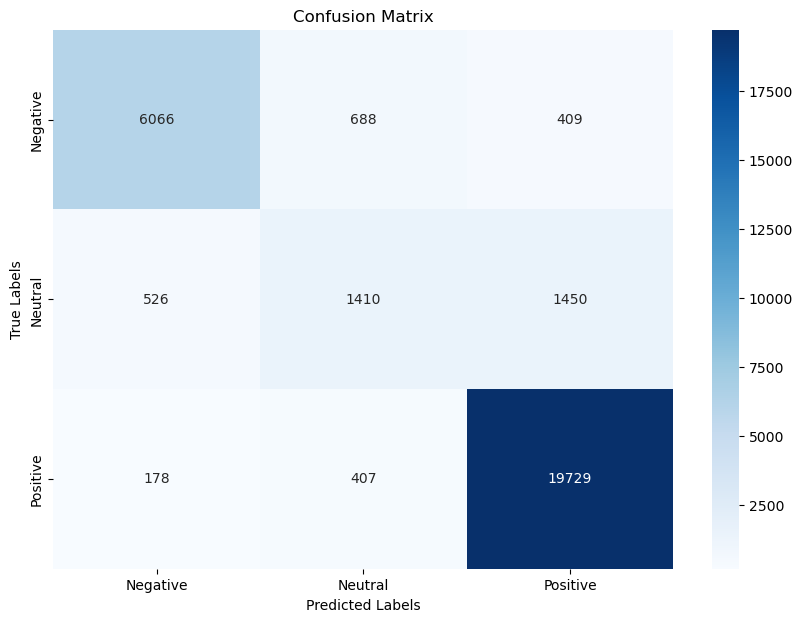

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


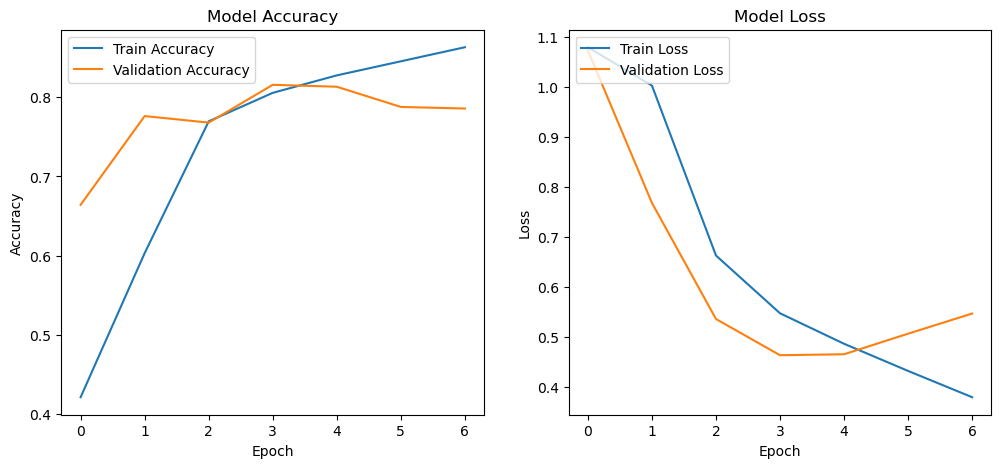

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()
